# Basic tutorial of the lgpr package
Here we generate an artificial longitudinal data set and analyse it.

In [1]:
require(lgpr)
require(repr)
require(ggplot2)

Loading required package: lgpr
This is lgpr, version 0.30.4.
Loading required package: repr
Loading required package: ggplot2


## 1. Simulating data
In this example we generate a data set with 16 individuals and 6 measurement time points for each. 

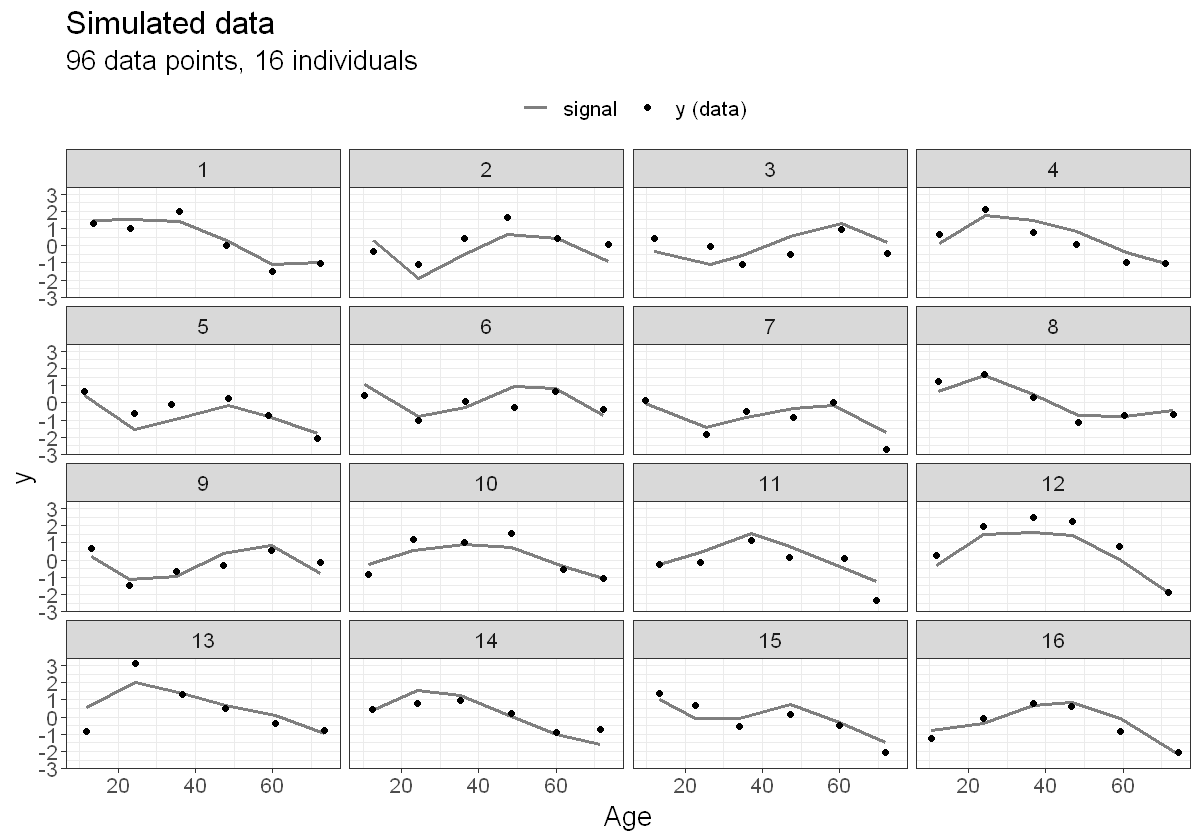

In [2]:
set.seed(321)
simData <- simulate_data(N           = 16,
                        t_data       = seq(12, 72, by = 12),
                        covariates   = c(    2,2),
                        lengthscales = c(12,24,12,12),
                        relevances   = c(1,1,1,0),
                        names        = c("sex", "location"),
                        t_jitter     = 1.0,
                        snr          = 3)

FONT_SIZE <- 16
options(repr.plot.width=10, repr.plot.height=7)

# plot data for each individual separately
plot_simdata(simData) + theme(text=element_text(size=FONT_SIZE)) 

As can be seen from the following plot, the data was generated so that covariates age, id, and sex are relevant, whereas location is not.

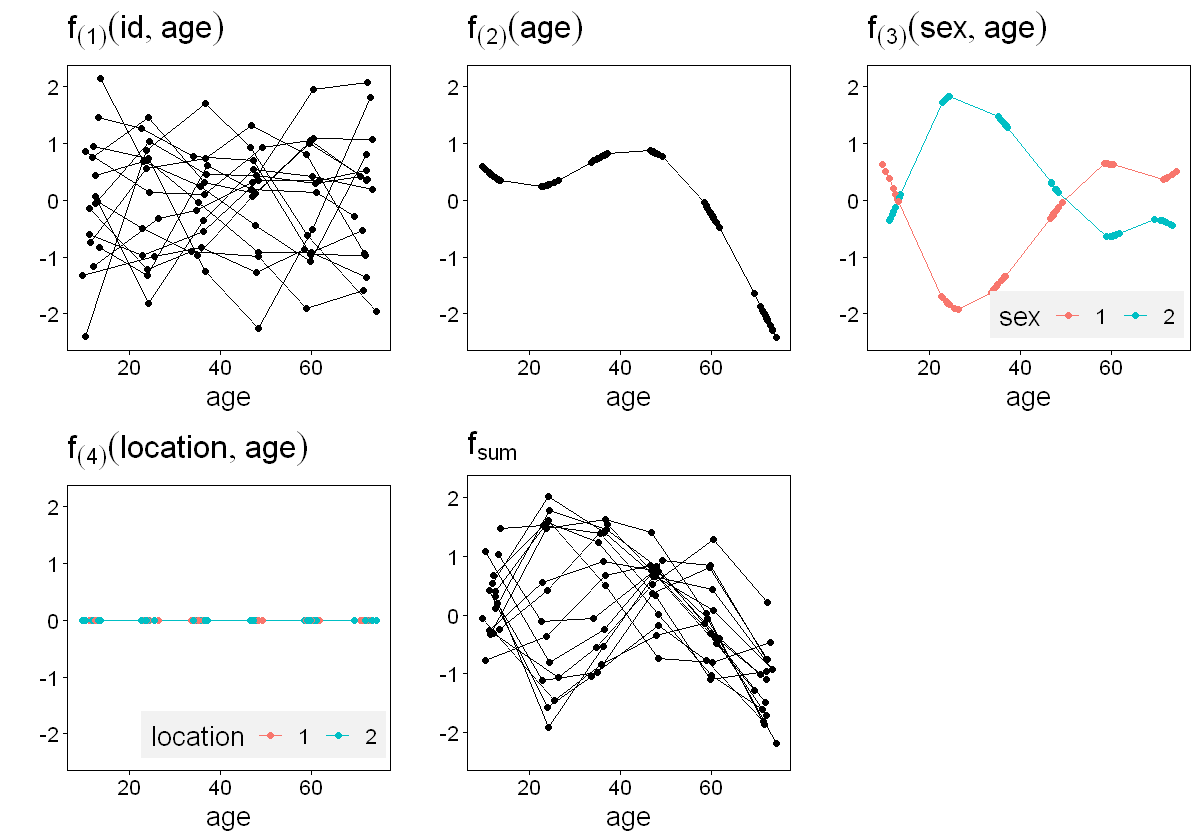

In [3]:
# plot each generated component separately
plot_components_simdata(simData, font_size = FONT_SIZE) 

## 2. Fitting a model
We fit a model with all covariates included. In general, it would be a good idea to use multiple, longer chains (arguments `iter` and `chains`).

In [4]:
fit <- lgp(formula  = y ~ id + age + sex + location,
           data     = simData$data,
           iter     = 2000, 
           chains   = 2,
           refresh  = 0,
           verbose  = TRUE)

* Covariate 'sex' resolved to type 'categorical'.
* Covariate 'location' resolved to type 'categorical'.

 ---------- LGPMODEL SUMMARY ----------

  Model:
    f = f[(1)](id, age) + f[(2)](age) + f[(3)](sex, age) + f[(4)](location, age)
    Response variable: y
    Observation model: Gaussian 
  Variable types:
    - Identifier variable: id
    - Time variable: age
    - Other categorical variables: sex, location
  Observation model: Gaussian

 ---------- PRIOR SPECIFICATIONS ----------

  alpha_id ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_age ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_categAge[1] ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_categAge[2] ~ Student-t(nu=20,mu=0,sigma=1)

  ell_id ~ Log-Normal(0,1)
  ell_age ~ Log-Normal(0,1)
  ell_categAge[1] ~ Log-Normal(0,1)
  ell_categAge[2] ~ Log-Normal(0,1)

  (sigma_n)^2 ~ Inverse-Gamma(2,1)

 
* Observation model = 1
* Number of data points = 96
* Number of model components = 4
* Number of individuals = 16
* Additional model info:
  - C_hat

We can visualize the inferred covariate effects and confirm that the effect of location is very small compared to that of other covariates. 

* Computing predictions using MAP parameters. 


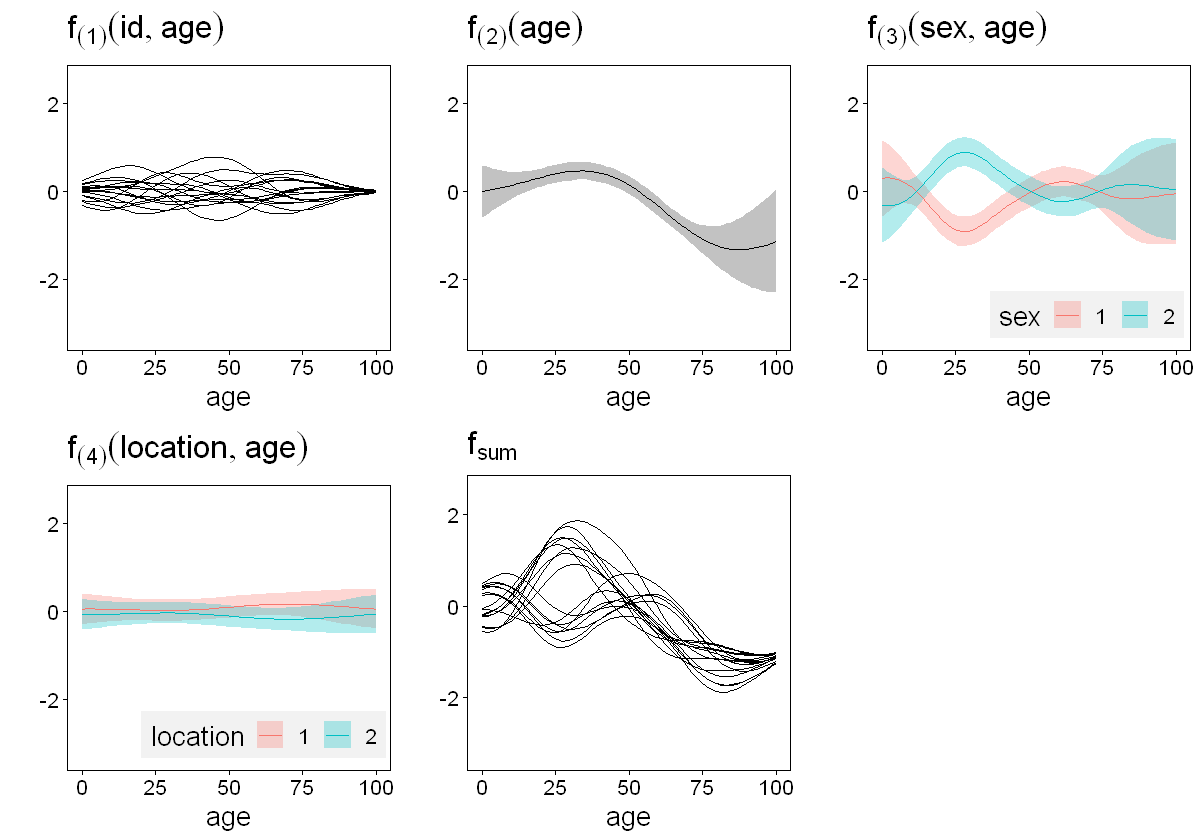

In [5]:
ttt    <- seq(0, 100, length.out = 60)
X_pred <- create_test_points(fit, ttt)
PRED   <- lgp_predict(fit, X_pred, samples = 'map')
p      <- plot_components_posterior(fit, PRED=PRED, font_size = FONT_SIZE)
p

Here we compute the posterior distributions of each component ($f_{(j)}$), and the sum of all components ($f_{sum}$) at a dense time grid of 100 points, using MAP hyperparameter estimates. For each component, the shaded ribbons indicate the $95\%$ posterior interval, and the solid lines are the posterior mean. To confirm that the fitted model makes sense, we can plot the posterior predictive distribution of the model, for each individual, along with the data points.

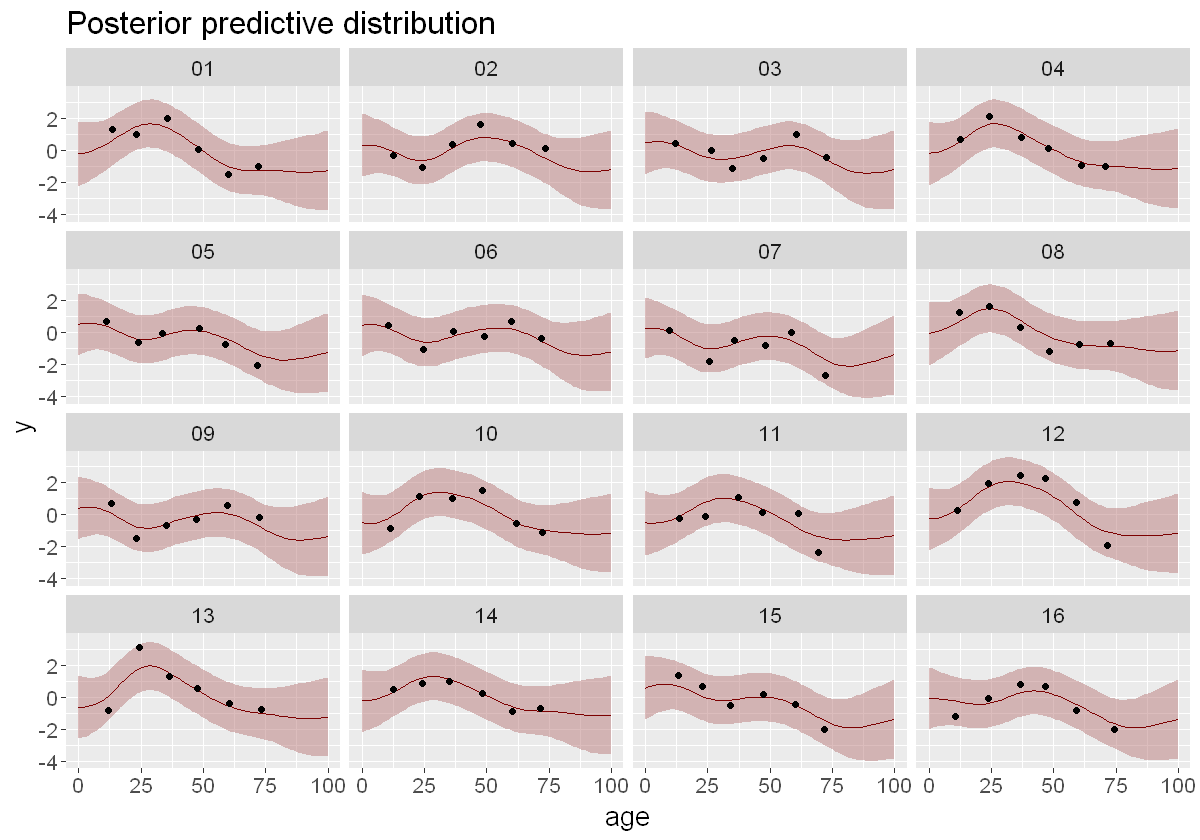

In [6]:
plot_posterior_y(fit, PRED) + theme(text=element_text(size=FONT_SIZE))

## 3. Component relevances and selection probabilities

In [7]:
print(fit)


 ---------- LGPFIT SUMMARY ----------

* Average runtime per chain: 80.6 s (warmup) and 69.55 s (sampling)
* Largest R-hat value is 1.0072 (sigma_n[1])
* Used relevance method = f_mean
* Used selection threshold = 0.95

                      Relevance Selected  Prob.
f[(1)](id, age)           0.086     TRUE 0.5930
f[(2)](age)               0.316     TRUE 1.0000
f[(3)](sex, age)          0.242     TRUE 0.9995
f[(4)](location, age)     0.009    FALSE 0.0000
noise                     0.346     TRUE 1.0000



The component relevances, non-probabilistic selection results and selection probabilities are reported above. As is seen, the location component is not selected and therefore correctly classified as irrelevant. The following plot shows the distribution of relevance for each component over all posterior samples.

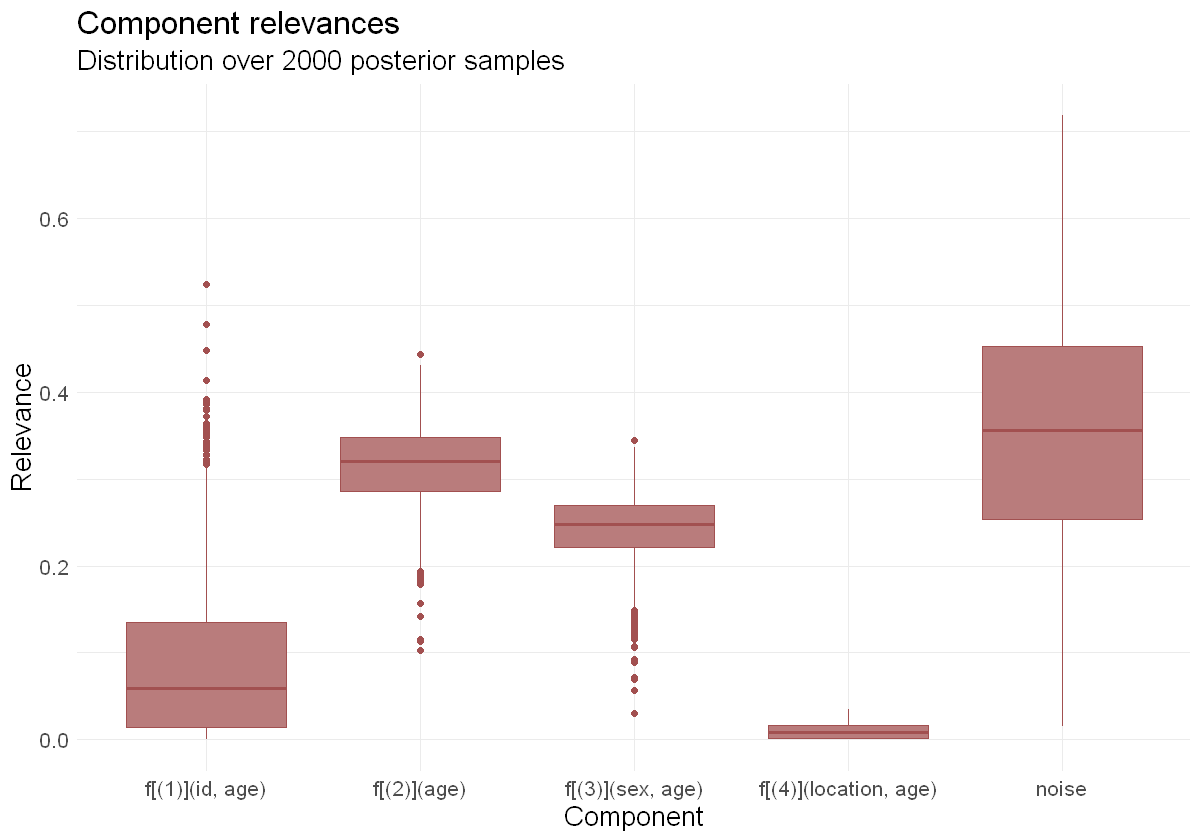

In [8]:
plot(fit) + theme(text=element_text(size=FONT_SIZE))

## 4. Selection probabilities with uncertain threshold
We can visualize the selection probability of each component as a function of the threshold.

      f[(1)](id, age)           f[(2)](age)      f[(3)](sex, age) 
               0.6049                1.0000                0.9996 
f[(4)](location, age) 
               0.0300 


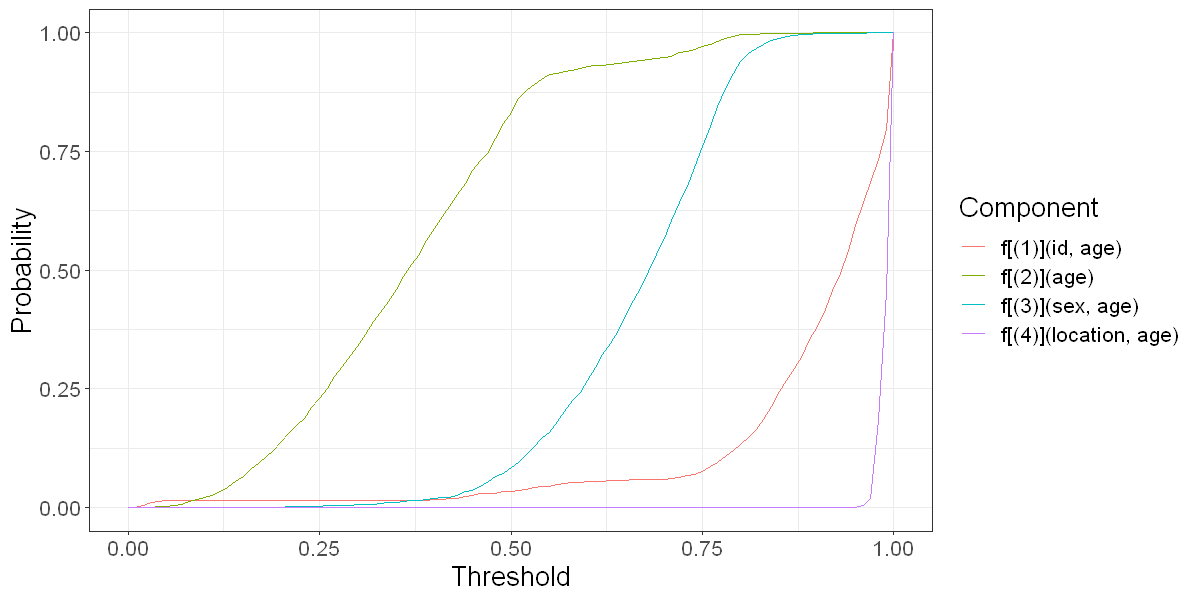

In [9]:
options(repr.plot.width=10, repr.plot.height=5)
sel <- selection_prob(fit)
print(round(sel$prob, 4)) # print selection probabilities, computed by weighing thresholds with Beta(100,5)
plt <- sel$plot + theme_bw() + theme(text=element_text(size=FONT_SIZE))
plt